In [1]:
# import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# define global constants
images_filepath = "./CS4243_2023_images_small/"

In [3]:
# utility functions
def am_power(a):
    dim1 = a.shape
    if len(dim1) == 2:
        sz = dim1[0] * dim1[1] 
    elif len(dim1) == 3:
        sz = dim1[0] * dim1[1] * dim1[2]        
    pa = np.sum( a ** 2.0) / sz    
    return pa

def am_entropy(nimg , N=256):
    M = nimg.shape
    ssz = M[0] * M[1]
    hist, bins = np.histogram(nimg.flatten(), N, [0, N])
    hist = hist / ssz
    ent = -np.sum(hist * np.log2(hist + 0.000001))
    return ent

# Q1

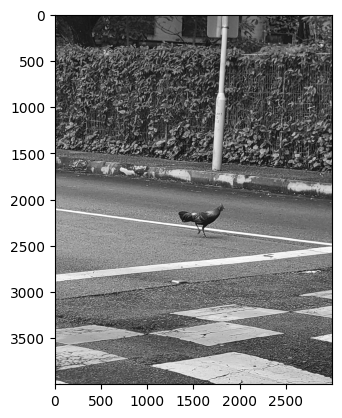

In [4]:
a = cv2.cvtColor(cv2.imread(images_filepath + "20220511_105950gl.jpg"), cv2.COLOR_BGR2GRAY)
plt.imshow(a, cmap="gray")

In [5]:
zoa = [cv2.resize(a, None, fx=0.25, fy=0.25, interpolation=x) for x in range(4)]
zia = [cv2.resize(zoa[x], None, fx=4, fy=4, interpolation=x) for x in range(4)]
adiffa = [np.sum(cv2.absdiff(a, zia[x])) for x in range(4)]
print(adiffa)
print(np.argsort(adiffa))

[152499390, 71430374, 52420526, 96442004]
[2 1 3 0]


# Q2

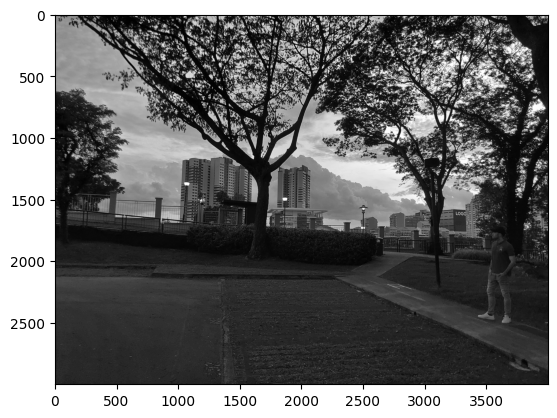

In [6]:
b = cv2.cvtColor(cv2.imread(images_filepath + "20230513_190534gl.jpg")[...,::-1], cv2.COLOR_BGR2GRAY)
plt.imshow(b, cmap="gray")

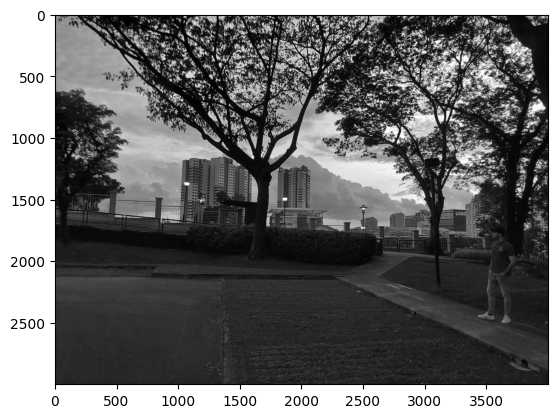

In [7]:
h_glp = np.array([
        [1,  4,  7,  4, 1],
        [4, 16, 26, 16, 4], 
        [7, 26, 41, 26, 7], 
        [4, 16, 26, 16, 4], 
        [1,  4,  7,  4, 1]]) / 273
b_glp = cv2.filter2D(b, -1, h_glp)
plt.imshow(b_glp, cmap="gray")

In [8]:
print("b power: {}".format(am_power(b)))
print("b entropy: {}".format(am_entropy(b)))
print("b_glp power: {}".format(am_power(b_glp)))
print("b_glp entropy: {}".format(am_entropy(b_glp)))

print("b power cut: {}%".format((am_power(b) - am_power(b_glp)) * 100 / am_power(b)))

b power: 9148.340999416667
b entropy: 7.34831646610579
b_glp power: 8787.92350775
b_glp entropy: 7.306948410221264
b power cut: 3.9397032936315846%


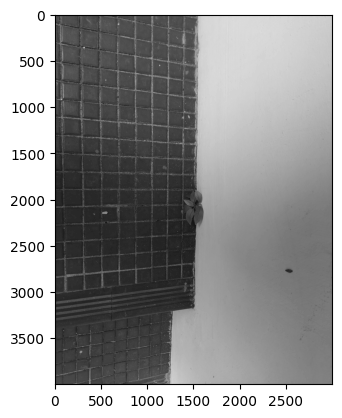

In [9]:
c = cv2.cvtColor(cv2.imread(images_filepath + "20230324_105524gl.jpg")[...,::-1], cv2.COLOR_BGR2GRAY)
plt.imshow(c, cmap="gray")

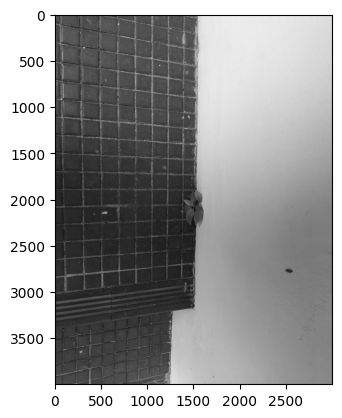

In [10]:
c_glp = cv2.filter2D(c, -1, h_glp)
plt.imshow(c_glp, cmap="gray")

In [11]:
print("c power: {}".format(am_power(c)))
print("c entropy: {}".format(am_entropy(c)))
print("c_glp power: {}".format(am_power(c_glp)))
print("c_glp entropy: {}".format(am_entropy(c_glp)))

print("c power cut: {}%".format((am_power(c) - am_power(c_glp)) * 100 / am_power(c)))

c power: 16307.88450275
c entropy: 7.418215557798164
c_glp power: 16282.990728583334
c_glp entropy: 7.378689527012116
c power cut: 0.15264870291709012%


# Q3

In [12]:
def ButterworthLowPass(M, N, D0, n_o):
    filter = np.zeros((M, N))
    D0 = D0 * min(M, N) / 2
    n_o = 2 * n_o
    for i in range(M):
        for j in range(N):
            d = ((i - M / 2) ** 2 + (j - N / 2) ** 2) ** 0.5
            filter[i, j] = 1 / (1 + (d / D0) ** n_o)            
    return filter

def ButterworthBandPass(M, N, D0, D1, n_o):
    filter = ButterworthLowPass(M, N, D0, n_o)
    filter = ButterworthLowPass(M, N, D1, n_o) - filter
    filter = filter * (1 / np.max(filter)) 
    return filter

def FFT_Shift(img):
    f = np.fft.fft2(img)
    f_shift = np.fft.fftshift(f)    
    return f_shift

def InvertFFT(idft_shift):
    ifimg = np.fft.ifft2(idft_shift)    
    return np.abs(ifimg)

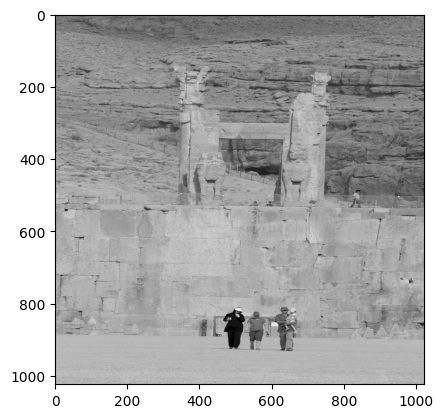

In [13]:
c = cv2.imread(images_filepath + "IMG_0699_1024.png", 0)[...,::-1]
plt.imshow(c, cmap="gray")

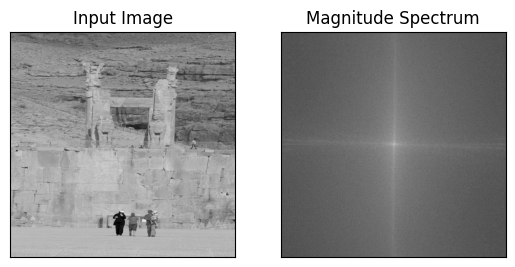

In [14]:
c_ft_shift = FFT_Shift(c)

magnitude_spectrum =  80 * np.log(np.abs(c_ft_shift))

plt.subplot(121), plt.imshow(c, cmap="gray")
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap="gray")
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [15]:
F0 = ButterworthBandPass(1024, 1024, 0.05, 0.1, 1)
F1 = ButterworthBandPass(1024, 1024, 0.1, 0.2, 1)
F2 = ButterworthBandPass(1024, 1024, 0.2, 0.4, 1)
F3 = ButterworthBandPass(1024, 1024, 0.4, 0.8, 1)
F = [F0, F1, F2, F3]

In [16]:
c_ft_shift_abs = np.abs(c_ft_shift)
c_ft_shift_phase = np.angle(c_ft_shift)

FcF = [np.multiply(c_ft_shift_abs, F[i]) for i in range(4)]

In [17]:
z = [np.multiply(Fc, np.exp((1j) * (c_ft_shift_phase))) for Fc in FcF]

In [18]:
inverse_FcF = [InvertFFT(img) for img in z]

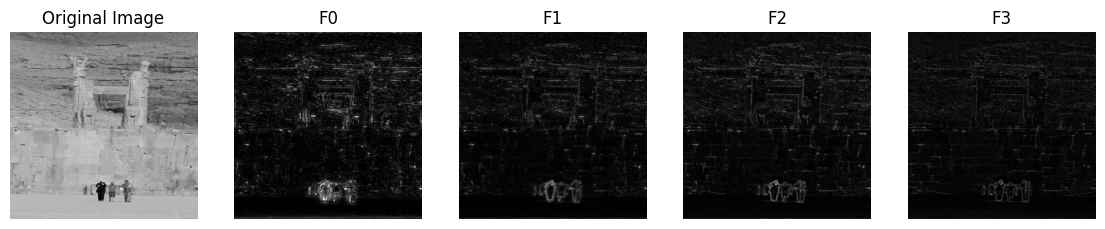

In [19]:
plt.figure(figsize=(14, 10))
plt.subplot(151), plt.imshow(c, 'gray'), plt.title('Original Image')
plt.axis('off')
plt.subplot(152), plt.imshow(np.uint8(inverse_FcF[0]), 'gray'), plt.title('F0')
plt.axis('off')
plt.subplot(153), plt.imshow(np.uint8(inverse_FcF[1]), 'gray'), plt.title('F1')
plt.axis('off')
plt.subplot(154), plt.imshow(np.uint8(inverse_FcF[2]), 'gray'), plt.title('F2')
plt.axis('off')
plt.subplot(155), plt.imshow(np.uint8(inverse_FcF[3]), 'gray'), plt.title('F3')
plt.axis('off')
plt.show()

In [20]:
PcF = [am_power(f) for f in inverse_FcF]
print(PcF)

[157.70110624813603, 144.51206138536975, 123.45115106233567, 85.5551361134617]


# Q4

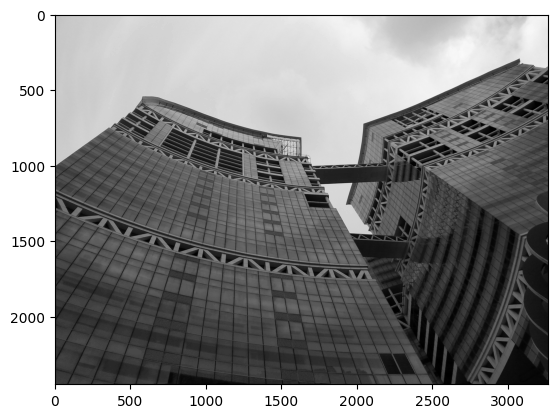

In [21]:
a = cv2.cvtColor(cv2.imread(images_filepath + "IMG_20200111_141756.jpg")[...,::-1], cv2.COLOR_BGR2GRAY)

plt.imshow(a, cmap="gray")


In [22]:
hved = np.array([
    [-1, 0, 1], 
    [-2, 0, 2], 
    [-1, 0, 1]])

In [23]:
pa = am_power(a)
pa

17675.233280669294

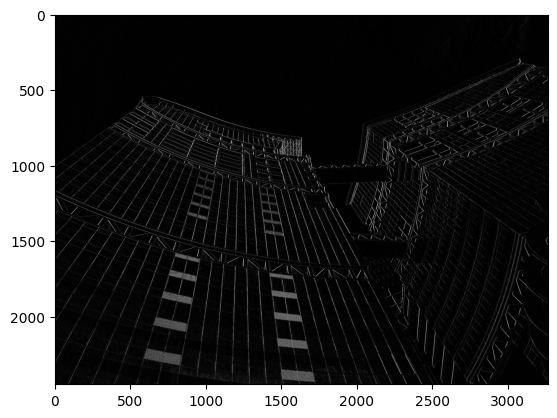

In [24]:
a_filtered = cv2.filter2D(a, -1, hved)
plt.imshow(a_filtered, cmap="gray")

In [25]:
phpa = am_power(a_filtered)
phpa

952.2007140683071

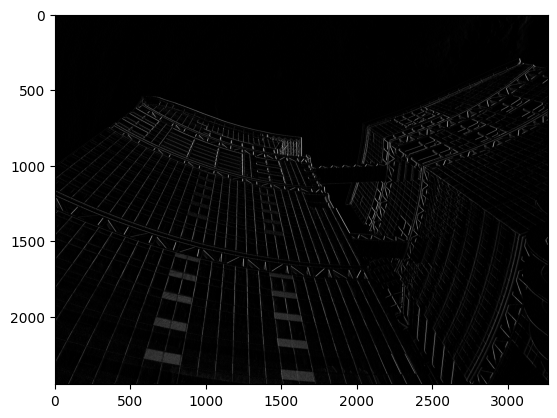

In [26]:
vert_then_gauss = cv2.filter2D(cv2.filter2D(a, -1, h_glp), -1, hved)

plt.imshow(vert_then_gauss, cmap="gray")

In [27]:
plphpa = am_power(vert_then_gauss)
plphpa

451.0324488327807

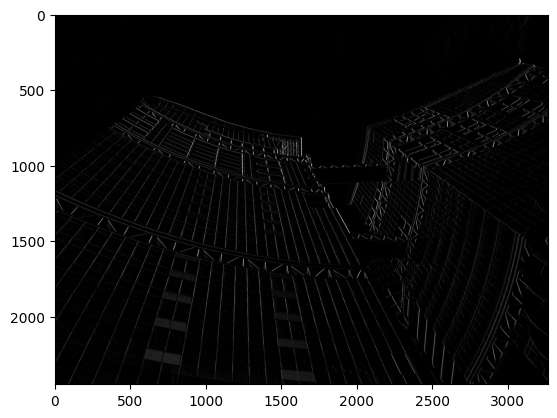

In [28]:
gauss_then_gauss_then_vert = cv2.filter2D(cv2.filter2D(cv2.filter2D(a, -1, h_glp), -1, h_glp), -1, hved)

plt.imshow(gauss_then_gauss_then_vert, cmap="gray")

In [29]:
plplphpa = am_power(gauss_then_gauss_then_vert)
plplphpa

286.1823458575628

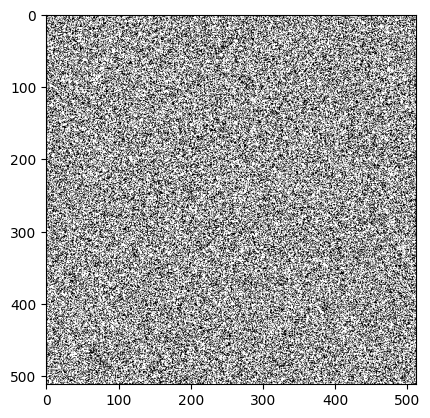

In [30]:
b = cv2.cvtColor(cv2.imread(images_filepath + "high_spat_freq.bmp")[...,::-1], cv2.COLOR_BGR2GRAY)

plt.imshow(b, cmap="gray")

In [31]:
pb = am_power(b)
pb

37922.38235473633

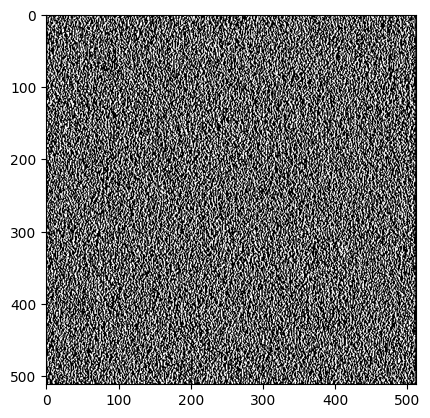

In [32]:
b_filtered = cv2.filter2D(b, -1, hved)
plt.imshow(b_filtered, cmap="gray")

In [33]:
phpb = am_power(b_filtered)
phpb

24450.582790374756

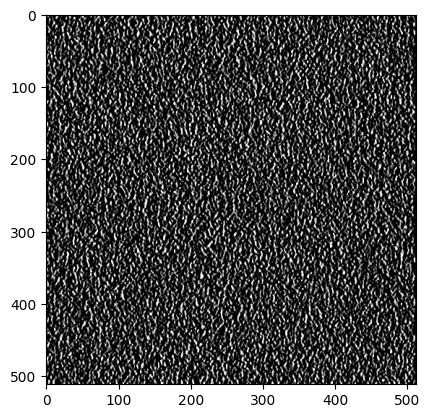

In [34]:
vert_then_gauss = cv2.filter2D(cv2.filter2D(b, -1, h_glp), -1, hved)

plt.imshow(vert_then_gauss, cmap="gray")

In [35]:
plphpb = am_power(vert_then_gauss)
plphpb

8343.05661392212

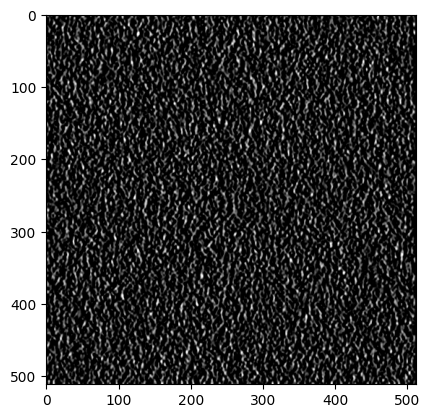

In [36]:
gauss_then_gauss_then_vert = cv2.filter2D(cv2.filter2D(cv2.filter2D(b, -1, h_glp), -1, h_glp), -1, hved)

plt.imshow(gauss_then_gauss_then_vert, cmap="gray")

In [37]:
plplphpb = am_power(gauss_then_gauss_then_vert)
plplphpb

3231.2771224975586

In [38]:
plplphpa / phpa

0.3005483419927715

In [39]:
plplphpb / phpb

0.13215542345966438